# <center>Comparing DBSCAN and HDBSCAN clustering

The two clustering models will be trained using data curated by StatCan containing the names, types, and locations of cultural and art facilities across Canada. Focus will be on the museum locations provided across Canada.

In [1]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

# Geographical tools
import geopandas as gpd # pandas dataframe-like geodataframes for geographical data
import contextily as ctx # used for obtianing a basemap of Canada
from shapely.geometry import Point

# Functions
# Add the src folder to the Python path so 
sys.path.append(os.path.abspath('../src'))

from data_loader import load_museum_data, download_and_extract_tif
from plotter import plot_clustered_locations

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Data Exploration

In [2]:
# Download and extract Canada map for reference
zip_file_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'
download_and_extract_tif(zip_file_url)

Downloaded and extracted: Canada.tif


'/Users/dave/Downloads/IBM-Generative-AI/Comparing_DBSCAN_and_HDBSCAN/data/Canada.tif'

In [3]:
# Load data and preview museum dataset
csv_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = load_museum_data(csv_url)
df.head()


Detected encoding: Windows-1252


Index                      Facility_Name            Source_Facility_Type  \
0      1                   #Hashtag Gallery                              ..   
1      2  'Ksan Historical Village & Museum  historic site-building or park   
2      3               'School Days' Museum       community/regional museum   
3      4                   10 Austin Street       built heritage properties   
4      5              10 Gates Dancing Inc.                            arts   

         ODCAF_Facility_Type                      Provider Unit Street_No  \
0                    gallery                       toronto   ..       801   
1                     museum  canadian museums association   ..      1500   
2                     museum  canadian museums association   ..       427   
3  heritage or historic site                       moncton   ..        10   
4              miscellaneous                        ottawa   ..        ..   

   Street_Name Postal_Code         City Prov_Terr  \
0  dundas st w     M6J 1V2      toronto        on   
1       62 hwy     V0J 1Y0     hazelton        bc   
2     queen st     E3B 5R6  fredericton        nb   
3    austin st     E1C 1Z6      moncton        nb   
4           ..          ..       ottawa        on   

                               Source_Format_Address     CSD_Name   CSDUID  \
0                                    801 dundas st w      Toronto  3520005   
1  1500 hwy 62 hazelton british columbia v0j 1y0 ...     Hazelton  5949022   
2  427 queen st fredericton new brunswick e3b 5r6...  Fredericton  1310032   
3                                       10 austin st      Moncton  1307022   
4                                                 ..       Ottawa  3506008   

  PRUID     Latitude     Longitude  
0    35  43.65169472  -79.40803272  
1    59   55.2645508  -127.6428124  
2    13    45.963283   -66.6419017  
3    13  46.09247776  -64.78022946  
4    35  45.40856224  -75.71536766

In [4]:
# Check for missing values
df.isna().sum()

Index                    0
Facility_Name            0
Source_Facility_Type     0
ODCAF_Facility_Type      0
Provider                 0
Unit                     0
Street_No                0
Street_Name              0
Postal_Code              0
City                     0
Prov_Terr                0
Source_Format_Address    0
CSD_Name                 0
CSDUID                   0
PRUID                    0
Latitude                 0
Longitude                0
dtype: int64

The missing values are represented by '..'

In [5]:
# Replace '..' with real NaNs
df.replace('..', np.nan, inplace=True)

#Check missing values
df.isna().sum()

Index                       0
Facility_Name               4
Source_Facility_Type     2533
ODCAF_Facility_Type         0
Provider                    0
Unit                     7623
Street_No                1284
Street_Name              1149
Postal_Code              1454
City                      116
Prov_Terr                   2
Source_Format_Address     804
CSD_Name                  301
CSDUID                    301
PRUID                      90
Latitude                 1224
Longitude                1224
dtype: int64

In [6]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972 entries, 0 to 7971
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Index                  7972 non-null   int64 
 1   Facility_Name          7968 non-null   object
 2   Source_Facility_Type   5439 non-null   object
 3   ODCAF_Facility_Type    7972 non-null   object
 4   Provider               7972 non-null   object
 5   Unit                   349 non-null    object
 6   Street_No              6688 non-null   object
 7   Street_Name            6823 non-null   object
 8   Postal_Code            6518 non-null   object
 9   City                   7856 non-null   object
 10  Prov_Terr              7970 non-null   object
 11  Source_Format_Address  7168 non-null   object
 12  CSD_Name               7671 non-null   object
 13  CSDUID                 7671 non-null   object
 14  PRUID                  7882 non-null   object
 15  Latitude             

In [7]:
# Count of facility types
df[['ODCAF_Facility_Type']].value_counts()

ODCAF_Facility_Type                 
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

In [8]:
# Filter Facility Type to 'museum'
df = df[df['ODCAF_Facility_Type']=='museum']
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64

In [9]:
# Select only the Latitude and Longitude features as inputs to our clustering problem
df = df[['Latitude', 'Longitude']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1607 non-null   object
 1   Longitude  1607 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [10]:
# Change data type to float
# Remove missing values
# Remove observations with no coordinates 
df = df.dropna()
df['Latitude'] = df['Latitude'].astype('float64')
df['Longitude'] = df['Longitude'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1607 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   1607 non-null   float64
 1   Longitude  1607 non-null   float64
dtypes: float64(2)
memory usage: 37.7 KB


### Build a DBSCAN model

In [11]:
# Correctly scale the coordinates for DBSCAN (since DBSCAN is sensitive to scaling)
# In this case we know how to scale the coordinates. Using standardization would be an error becaues we aren't using the full range of the lat/lng coordinates.
# Since latitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees, the correct scaling is to double the longitude coordinates (or half the Latitudes)
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

In [12]:
# Apply DBSCAN with Euclidean distance to the scaled coordinates
min_samples=3 # minimum number of samples needed to form a neighbourhood
eps=1.0 # neighbourhood search radius
metric='euclidean' # distance measure 

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(coords_scaled)

In [13]:
# Add cluster labels to the DataFrame
df['Cluster'] = dbscan.fit_predict(coords_scaled)  # Assign the cluster labels

# Display the size of each cluster
df['Cluster'].value_counts()

Cluster
 4     701
 2     192
 1     181
 7     134
 3      94
-1      79
 6      30
 10     27
 8      21
 11     15
 15     13
 20     11
 16     10
 19      9
 27      8
 12      7
 24      6
 18      6
 28      6
 26      6
 14      6
 5       6
 22      4
 9       4
 13      4
 30      3
 31      3
 29      3
 0       3
 25      3
 23      3
 21      3
 17      3
 32      3
Name: count, dtype: int64

There are two relatively large clusters and 79 points labelled as noise (-1).

### Plot the museums on a basemap of Canada, colored by cluster label.

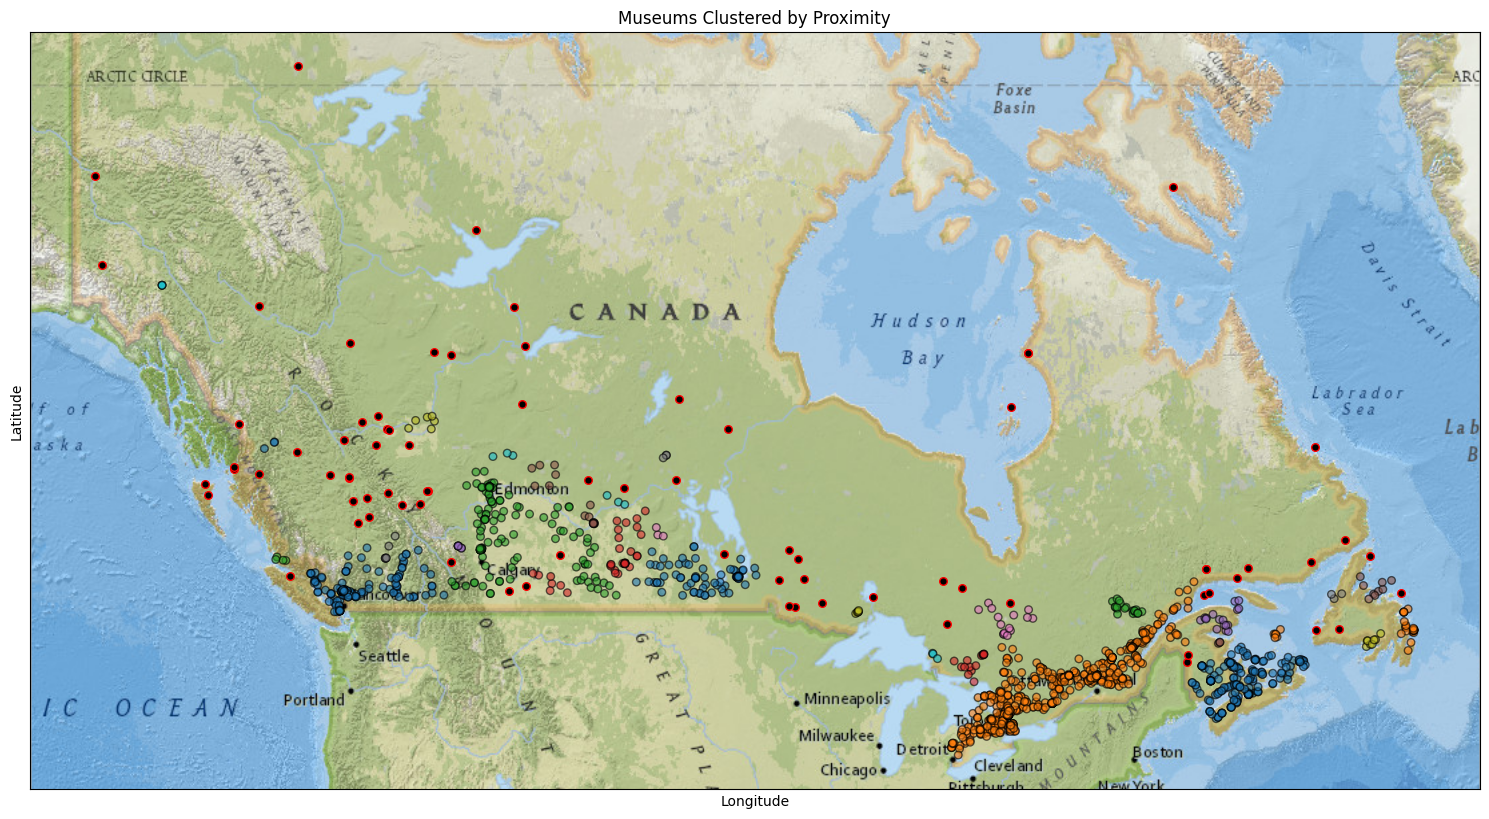

In [14]:
# Plot clustered locations
plot_clustered_locations(df, title='Museums Clustered by Proximity')

The clusters are not uniformly dense.

For example, the points are quite densely packed in a few regions but are relatively sparse in between.

DBSCAN agglomerates neighboring clusters together when they are close enough.

### Build an HDBSCAN model

In [18]:
# Initialize HDBSCAN
min_samples=None
min_cluster_size=3
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='euclidean')

In [19]:
# Assign cluster labels to the DataFrame
df['Cluster'] = hdb.fit_predict(coords_scaled)

# Display the size of each cluster
df['Cluster'].value_counts()

Cluster
-1      464
 137     45
 91      39
 66      35
 84      29
       ... 
 128      3
 109      3
 40       3
 123      3
 132      3
Name: count, Length: 141, dtype: int64

Unlike the case for DBSCAN, clusters quite uniformly sized, although there is a quite lot of noise identified.

Plot of the hierarchically clustered museums on a basemap of Canada, colored by cluster label

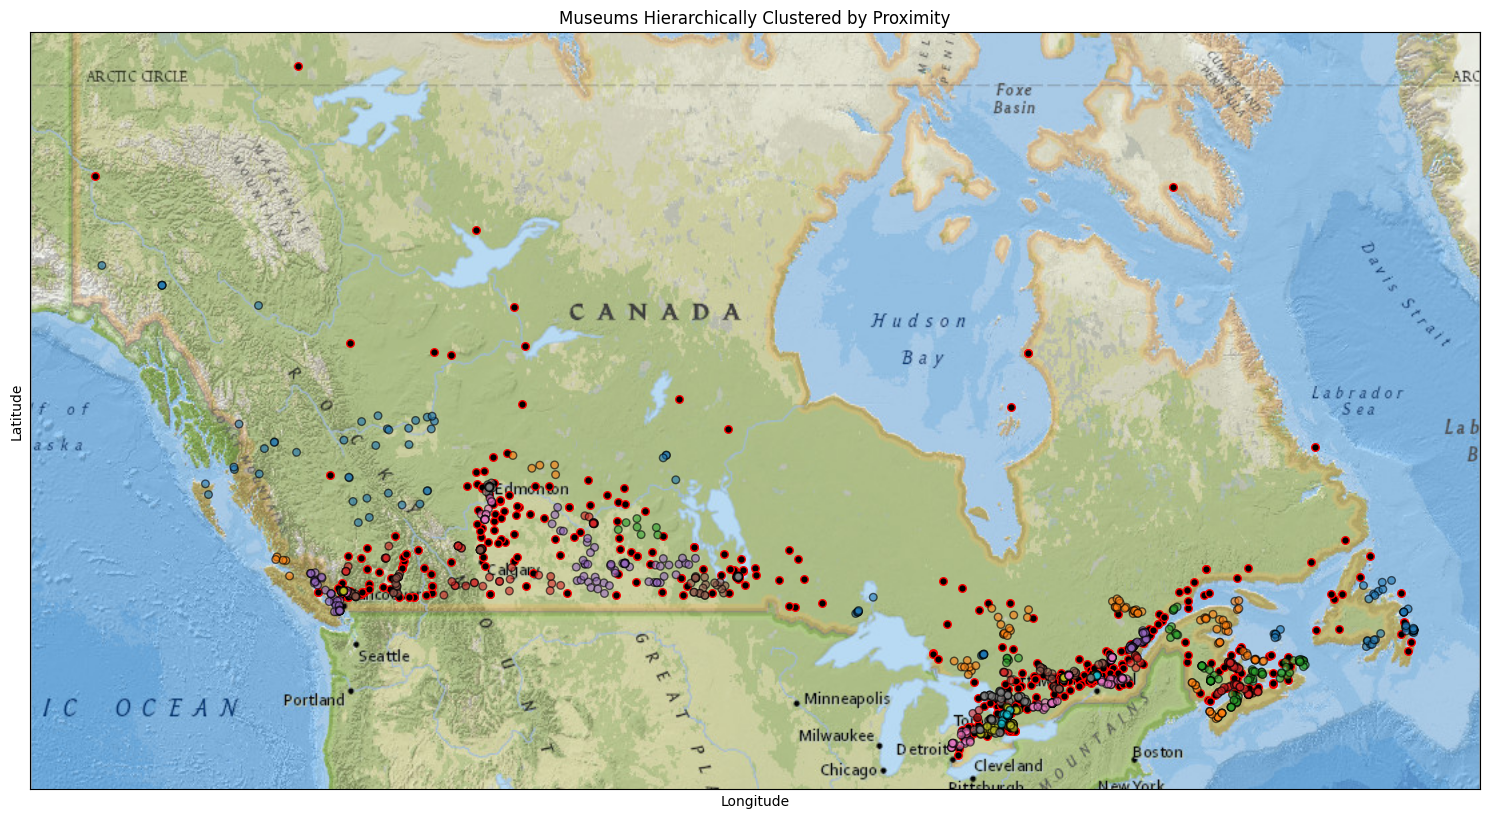

In [20]:
# Plot clustered locations
plot_clustered_locations(df, title='Museums Hierarchically Clustered by Proximity')